In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-06-18 21:09:11.326406: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-18 21:09:11.332718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-18 21:09:11.332741: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

### Loading the Full prepared dataset  cleaned data using nltk library- FakeNewsNet

In [2]:
#creating a data frame
df = pd.read_csv("Updated//full_dataset_fakenewsnet_cleaned_using_nltk.csv")

In [3]:
#df.head(2)

In [4]:
df['fulltext'].head(1)

0    Rick Santorum: By amending constitution, we can balance the budget for good.Rick Santorum: By amending constitution, we can balance the budget for good\n\nBy RICK SANTORUM\n\nLast summer, we saw a...
Name: fulltext, dtype: object

In [5]:
df['fulltext'].isnull().sum()

0

In [6]:
df = df[df['fulltext'].notna()]

In [7]:
df.shape

(20362, 10)

In [28]:
df['fulltext'].isnull().sum()

0

In [9]:
#https://androidkt.com/simple-text-classification-using-bert-in-tensorflow-keras-2-0/

In [10]:
# bert preprocessor - https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

#encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2",trainable=True)

2022-06-18 21:09:33.394195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-18 21:09:33.394651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-18 21:09:33.394795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['fulltext'], df['class'], test_size=0.2,stratify=df['class'], random_state=0)

In [12]:
train_texts=X_train
train_y=y_train

In [13]:
inputs_train=preprocessor(train_texts)

In [14]:
test_texts=X_test
test_y=y_test

In [15]:
inputs_test=preprocessor(test_texts)

In [70]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");

### LSTM

In [22]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNetLSTM_BERT.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [75]:
clear_session()

In [74]:
MAX_SEQ_LEN=128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="input_type_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
clf_output = sequence_output
#x=tf.keras.layers.SpatialDropout1D(0.2)(clf_output)
x=tf.keras.layers.LSTM(256,return_sequences=True,name="lstm_1")(clf_output)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu", name="dense_layer_1")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_output")(x)

lstm_model2 = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, input_type_ids], outputs=out)

lstm_model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [76]:
history_lstm_bert2=lstm_model2.fit(inputs_train,train_y,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7522 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b5c1611fd90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: loss did not improve from 0.63204
102/102 [==============================] - 1258s 12s/step - loss: 0.6812 - accuracy: 0.7522 - val_loss: 0.6696 - val_accuracy: 0.7508
Epoch 2/2
102/102 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7522 
Epoch 2: loss did not improve from 0.63204
102/102 [==============================] - 1200s 12s/step - loss: 0.6591 - accuracy: 0.7522 - val_loss: 0.6494 - val_accuracy: 0.7508


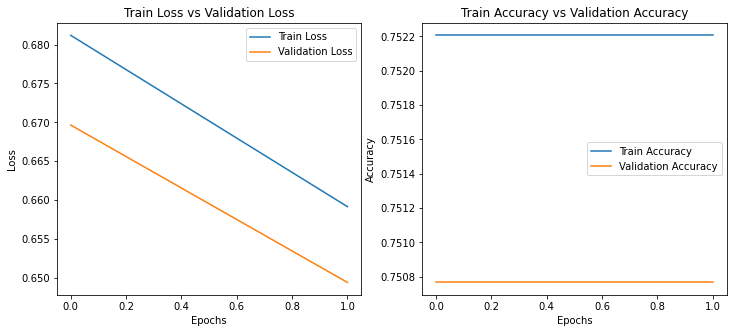

In [77]:
plot_loss_and_acc(history_lstm_bert2)

### 1d CNN

In [35]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNetCNN_BERT.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [80]:
MAX_SEQ_LEN=128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="input_type_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
clf_output = sequence_output
x= tf.keras.layers.Conv1D(256,kernel_size=3,padding='same', activation='relu')(clf_output)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
#x = tf.keras.layers.Dense(128, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, input_type_ids], outputs=out)

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [81]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     multiple             109482241   ['input_word_ids[0][0]',         
                                                                  'input_mask[0][0]',       

In [82]:
clear_session()

In [83]:
history_cnn_bert=model.fit(inputs_train,train_y,epochs=3,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
66/66 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7522 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b5b0fe90510> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: loss did not improve from 0.63204
66/66 [==============================] - 1253s 19s/step - loss: 0.6853 - accuracy: 0.7522 - val_loss: 0.6774 - val_accuracy: 0.7508
Epoch 2/3
66/66 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7522 
Epoch 2: loss did not improve from 0.63204
66/66 [==============================] - 1227s 19s/step - loss: 0.6703 - accuracy: 0.7522 - val_loss: 0.6632 - val_accuracy: 0.7508
Epoch 3/3
66/66 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.7522 
Epoch 3: loss did not improve from 0.63204
66/66 [==============================] - 1221s 19s/step - loss: 0.6567 - accuracy: 0.7522 - val_loss: 0.650

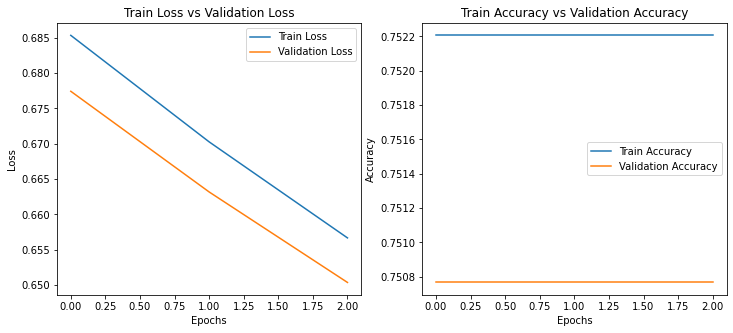

In [85]:
plot_loss_and_acc(history_cnn_bert)

###  Bi LSTM

In [86]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNetBiLSTM_BERT.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [87]:
clear_session()

In [92]:
MAX_SEQ_LEN=128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="input_type_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
clf_output = sequence_output
#x=tf.keras.layers.SpatialDropout1D(0.2)(clf_output)
x=tf.keras.layers.Bidirectional(LSTM(256,return_sequences=True,name="bilstm_1"))(clf_output)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dense(128, activation="relu", name="dense_layer_1")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_output")(x)

bilstm_model2 = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, input_type_ids], outputs=out)

bilstm_model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [93]:
history_bilstm_bert2=bilstm_model2.fit(inputs_train,train_y,epochs=2,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
66/66 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.7522 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b5bae865840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 1: loss improved from inf to 0.68542, saving model to Updated/modelFakeNewsNetBiLSTM_BERT.h5
66/66 [==============================] - 1302s 19s/step - loss: 0.6854 - accuracy: 0.7522 - val_loss: 0.6775 - val_accuracy: 0.7508
Epoch 2/2
66/66 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7522 
Epoch 2: loss improved from 0.68542 to 0.67029, saving model to Updated/modelFakeNewsNetBiLSTM_BERT.h5
66/66 [==============================] - 1271s 19s/step - loss: 0.6703 - accuracy: 0.7522 - val_loss: 0.6632 - val_accuracy: 0.7508


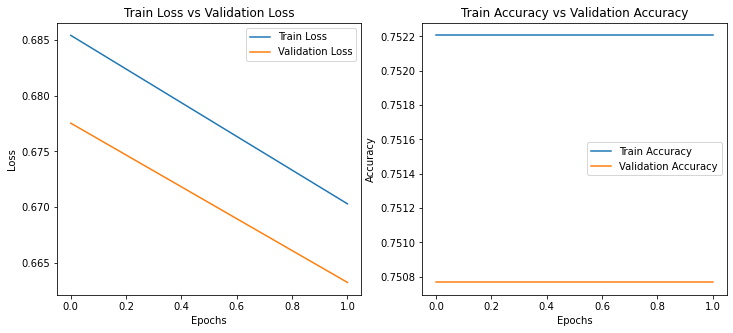

In [94]:
plot_loss_and_acc(history_bilstm_bert2)